- 회귀의 경우 오차를 기반으로 MSE, MAE, RMSE, R^ 등으로 간단히 계산 할 수 있다
- 분류의 경우 정확도(Accuracy) 외에도 여러가지 지표로 판단이 필요하고, target 의 class 가 Binary or Multi 인지에 따라서도 사용하는 지표가 달라지게된다. 

In [58]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.model_selection import train_test_split

data = load_breast_cancer()
X = data.data
y = data.target

# 훈련 데이터와 테스트 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

1. 정확도 (Accuracy) 

2. 오차행렬 (Confusion-Matrix) - 정확도, 정밀도, 재현율, F1 Score
- Precision(정밀도)은 T 라고 예측했는데 실제 T 인경우. = 1 - α (Type-Ⅰ error). False alarm 을 줄이는것이 정밀도를 올리는 것. 
- Recall(재현율) = Sensitivity(민감도). 실제 T 인데 T 라고 예측한 경우. 1 - β (Type-Ⅱ erroe). 
- Precision 과 Recall 은 trade-off 관계. T(예를들어 고장,이상,인터락)을 적극적으로 예측할수록 Recall 좋고, 소극적으로 예측할수록 Precision 좋고. 
- F1 Score 는 Precision 과 Recall 의 조화 평균. 1에 가까울수록 균형이 잘잡힌 것. 

<img src="confusion_matrix.png" alt="Confusion Matrix" width="600">

In [59]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

3. 임계값(Threshold) 
- 지금까지 평가 지표는 P/N 의 결과값 기반으로 이루어졌다. 그런데 그 이전에, P/N 의 판단은 사실 특정한 임계값(Threshold)를 기준으로  판단된다. 
- 즉 predict 라는 API 는, 사실 predict_proba() 라는 예측 레이블(P/N) 각각의 확률을 반환해주는 API 에서 파생되었고 predict_proba 의 확률값을 가지고 P/N 을 판단하는 기준이 Threshold 로 디폴트는 50% 이지만 조정할 수 있다. 

In [60]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression()
lr_clf.fit(x_train, y_train)

pred = lr_clf.predict(x_test)
pred_proba = lr_clf.predict_proba(x_test)
print(pred.shape, pred_proba.shape)
print(pred[:3], pred_proba[:3], sep='\n')
print(pred_proba[1].sum())

(114,) (114, 2)
[1 0 0]
[[1.39288194e-01 8.60711806e-01]
 [9.99999999e-01 9.41778779e-10]
 [9.98811652e-01 1.18834761e-03]]
1.0


c:\Users\bmseo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [61]:
# 예측확률과 결과값 한눈에 보기
pred_proba_result = np.concatenate([np.round(pred_proba,2),pred.reshape(-1,1)],axis=1)
print(pred_proba_result[:3])

[[0.14 0.86 1.  ]
 [1.   0.   0.  ]
 [1.   0.   0.  ]]


In [62]:
# 임계값을 조절해가면서 평가하는 코드. 
thresholds = [0.4,0.45,0.5,0.55,0.6]

def get_clf_eval(y_test, pred):
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)    
    print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1 Score: {f1:.4f}')

def get_eval_by_threshold(y_test,pred_proba_c1,thresholds):
    for custom_threshold in thresholds:
        bz = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = bz.transform(pred_proba_c1)
        print('임계값:',custom_threshold)
        get_clf_eval(y_test,custom_predict)  # 정밀도, 정확도, 오차행렬 등 지표 반환하는 사용자 함수

pred_proba_class1 = pred_proba[:,1].reshape(-1,1)
       
get_eval_by_threshold(y_test,pred_proba_class1,thresholds)

임계값: 0.4
정확도: 0.9561, 정밀도: 0.9459, 재현율: 0.9859, F1 Score: 0.9655
임계값: 0.45
정확도: 0.9561, 정밀도: 0.9459, 재현율: 0.9859, F1 Score: 0.9655
임계값: 0.5
정확도: 0.9561, 정밀도: 0.9459, 재현율: 0.9859, F1 Score: 0.9655
임계값: 0.55
정확도: 0.9649, 정밀도: 0.9589, 재현율: 0.9859, F1 Score: 0.9722
임계값: 0.6
정확도: 0.9649, 정밀도: 0.9589, 재현율: 0.9859, F1 Score: 0.9722


4. ROC Curve 와 AUC 스코어 
- ROC 커브는 x축이 FPR : 실제 Negative 인데 Positive 라고 잘못예측할 확률, y축이 TPR(재현율) 실제 Positive 인데 Positive라고 잘 예측할 확률.
- 즉, Negative 일때도 잘맞추면서 (x가 작을때) Positive 일때도 잘맞추는 (y가 클때) 커브가 나오는 커브가 좋은 커브이고, 이때의 커브 밑 면적을 AUC (Area Under Curve) 라고 하며, AUC 가 1에 가까울 수록 좋은 모델이다. 
- x 축, 즉 FPR 을 조정하는 방법은 임계값을 낮출수록 Positive 라고 하기쉽기 때문에 FPR도 올라간다. 

<img src="AUC.png" alt="ROC curve & AUC score" width="600">

In [63]:
y_test

array([1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0])

In [64]:
from sklearn.metrics import roc_curve

#roc_curve : 실제클래스값과, Positive 의 확률을 입력파라미터로,, fpr/tpr/임계값 3가지를 반환
fprs, tprs, thresholds = roc_curve(y_test,pred_proba_class1)
#thresholds[0] 값은 max(예측확률)+1 로 임의 설정됨
thr_index = np.arange(1,thresholds.shape[0],1)
print(thr_index)

print('5-step으로 뽑은 샘플 임계값:',np.round(thresholds[thr_index],2))
print('샘플 임계값별 FPR:',np.round(fprs[thr_index],2))
print('샘플 임계값별 TPR:',np.round(tprs[thr_index],2))

[1 2 3 4 5]
5-step으로 뽑은 샘플 임계값: [1.   0.85 0.53 0.29 0.  ]
샘플 임계값별 FPR: [0.   0.   0.09 0.09 1.  ]
샘플 임계값별 TPR: [0.01 0.99 0.99 1.   1.  ]


AUC값: 0.9986898132983951


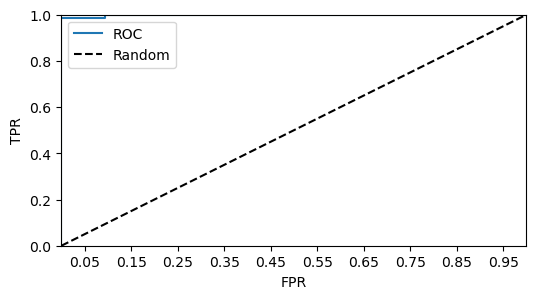

In [65]:
import matplotlib.pyplot as plt

# ROC 커브 그리기
def roc_curve_plot(y_test,pred_proba_c1):
    fprs, tprs, thresholds = roc_curve(y_test,pred_proba_c1)
    plt.figure(figsize=(6,3))
    plt.plot(fprs,tprs, label='ROC')
    plt.plot([0,1],[0,1],'k--',label='Random')
    start,end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlim(0,1);plt.ylim(0,1)
    plt.xlabel('FPR');plt.ylabel('TPR')
    plt.legend()
   
roc_curve_plot(y_test,pred_proba_class1)
# AUC 계산하기
from sklearn.metrics import roc_auc_score
roc_score = roc_auc_score(y_test,pred_proba_class1)
print('AUC값:',roc_score)